<a href="https://colab.research.google.com/github/fxop0218/PyTorchForBeginners/blob/main/02_multi_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-classification

**🟦EN** 
* Binary classification: One thing A or B, car or dog etc.
* Muli-classification: Multiple things: A, B or C, Cat, Dog or fish etc.

**🟥ES**: 
* Clasificación binaria: Una cosa A o B, coche o perro, etc.
* Clasificación múltiple: Múltiples cosas: A, B o C, gato, perro o pez, etc.

## 1 Creating dataset

In [105]:
# Imports
import matplotlib.pyplot as plt
import torch
import sklearn
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Hyperparameters
RANDOM_SEED = 10
NUM_CLASS = 4
NUM_FEATURES = 2

In [106]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [107]:
# Create multi-class data
X_blob, y_blob = make_blobs(n_samples = 1000, 
                            centers = NUM_CLASS,
                            cluster_std=1.5, # controls the standard deviation of the Gaussian distributions that are used to generate the blobs. Specifically, center_std is a list of standard deviations for each of the blobs.
                            n_features = NUM_FEATURES,
                            random_state = RANDOM_SEED)

In [108]:
# Import functions
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

In [109]:
# Turn into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float) 
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor) # If don't use LongTensro and use float, when using the loss function, an error will pop up

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X_blob, y_blob, train_size=0.8)

print(f"X_train len: {len(X_train)} || X_test len: {len(X_test)} || y_train len: {len(y_train)} || y_test len: {len(y_test)}")

X_train len: 800 || X_test len: 200 || y_train len: 800 || y_test len: 200


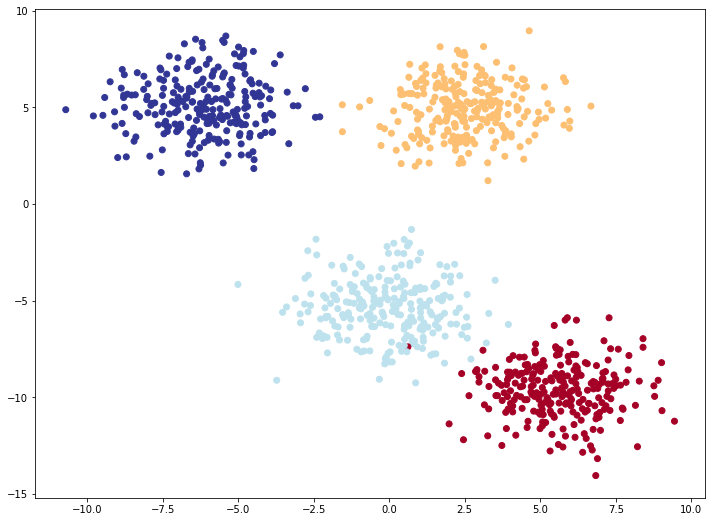

In [110]:
# Plot data

plt.figure(figsize=(12, 9))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)

## 2 Build multi-class PyTorch model

In [111]:
# Agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cpu


In [112]:
from torch import nn
# Build model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=20):
    """ INitializes multi-class classification model.
    Args: 
      Input_features (int): Number of input features to the model
      output_features (int): Number of outputs features (number of output classes)
      hidden units (int): Number of hidden units between layers, default 8

    Returns: 

    Exemple: 
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features),
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

In [113]:
# Get the input and output dimensions

INPUT_DIM = len(X_train.shape)
OUT_DIM = len(y_train.unique()) # Different class types

print(f"Input len: {INPUT_DIM} || Output len: {OUT_DIM}")

Input len: 2 || Output len: 4


In [114]:
model = BlobModel(input_features=INPUT_DIM,
                  output_features=OUT_DIM,
                  hidden_units=10).to(device)

print(f"Model info: {model}")

Model info: BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=4, bias=True)
  )
)


## 3. Create a loss function // optimizer

In [115]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.5)

## 4. Build a training loop

In [116]:
model.eval()

with torch.inference_mode(): 
  y_logits = model(X_test.to(device))

print(f"Raw predictions: {y_logits[:5]} || wanted prediction: {y_test[:5]}")

Raw predictions: tensor([[ 0.0367, -0.0891,  0.2223,  0.2752],
        [ 0.0368, -0.0684,  0.2377,  0.2573],
        [-0.0476, -0.1579,  0.1170,  0.2161],
        [-0.1191, -0.2189, -0.0421,  0.1693],
        [ 0.0498, -0.0378,  0.2293,  0.2505]]) || wanted prediction: tensor([2, 2, 0, 0, 2])


#### Softmax activation formula

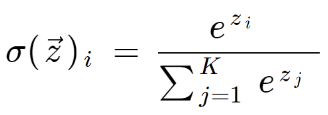

#### Softmax activation graph

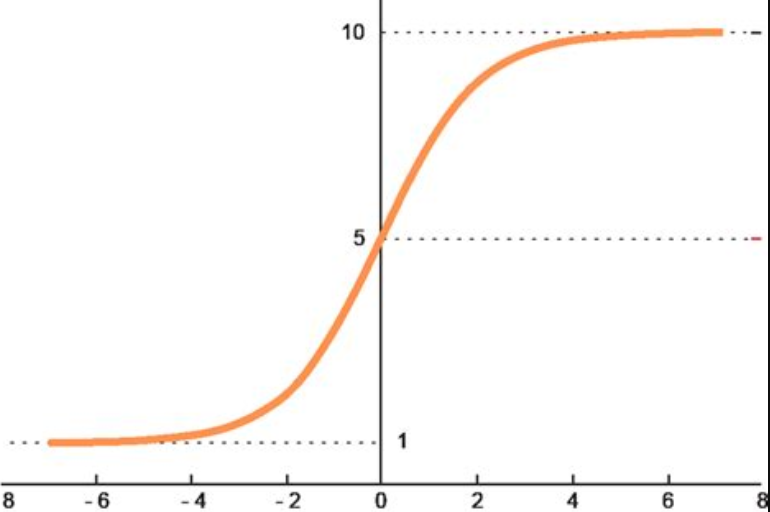

In [117]:
# Convert out model's prediction outputs into prediction probabilities

y_preds_probs = torch.softmax(y_logits, dim=1)
print(f"y_logits: {y_logits[:5]} || y_pred_probs: {y_preds_probs[:5]}")

y_logits: tensor([[ 0.0367, -0.0891,  0.2223,  0.2752],
        [ 0.0368, -0.0684,  0.2377,  0.2573],
        [-0.0476, -0.1579,  0.1170,  0.2161],
        [-0.1191, -0.2189, -0.0421,  0.1693],
        [ 0.0498, -0.0378,  0.2293,  0.2505]]) || y_pred_probs: tensor([[0.2296, 0.2025, 0.2765, 0.2915],
        [0.2289, 0.2060, 0.2798, 0.2853],
        [0.2285, 0.2046, 0.2694, 0.2974],
        [0.2315, 0.2095, 0.2501, 0.3089],
        [0.2307, 0.2113, 0.2760, 0.2820]])


**🟦EN**: The t_preds_probs represent the probability of belonging to one of the 4 classes, for this, we obtain the maximum value and put it in this class

**🟥ES**: Los t_preds_probs representan la probabilidad de pertenecer a una de las 4 clases, para ello, obtenemos el valor máximo y lo ponemos en esta clase


In [118]:
print(f"First tensor: {y_preds_probs[0]}\nMax number of tensor: {torch.max(y_preds_probs[0]):.4f}\nClass to which it belongs: {torch.argmax(y_preds_probs[0])}")

First tensor: tensor([0.2296, 0.2025, 0.2765, 0.2915])
Max number of tensor: 0.2915
Class to which it belongs: 3


In [119]:
y_preds = torch.argmax(y_preds_probs, dim = 1)
y_preds

tensor([3, 3, 3, 3, 3, 2, 2, 3, 0, 3, 3, 2, 3, 3, 0, 2, 3, 3, 2, 2, 3, 3, 3, 3,
        2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 0,
        3, 2, 3, 3, 2, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 0, 3, 0, 3, 2,
        0, 3, 3, 2, 2, 3, 3, 2, 2, 3, 3, 0, 0, 0, 2, 3, 3, 3, 3, 3, 2, 3, 3, 0,
        2, 3, 3, 3, 0, 3, 3, 3, 0, 3, 3, 3, 2, 2, 2, 3, 3, 3, 2, 0, 3, 0, 2, 2,
        3, 3, 3, 0, 2, 3, 3, 3, 2, 2, 2, 3, 3, 3, 3, 3, 3, 2, 3, 3, 0, 3, 0, 3,
        2, 2, 3, 3, 2, 2, 2, 3, 3, 0, 3, 0, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 2, 2,
        3, 2, 3, 3, 3, 2, 2, 3, 2, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 0, 3, 3,
        3, 3, 2, 3, 3, 2, 3, 3])

## 5. Getting predictions probabilities for a multi-class PyTorch model

**🟦EN**: In order to evaluate and train / test the model, we nned to convert le logits (output) to prediction probabilities and them to predicion labels

Raw output => prediction probabilities => Prediction labels

**🟥ES**: Para evaluar y entrenar/probar el modelo, necesitamos convertir los logits (resultados) en probabilidades de predicción y éstas en etiquetas de predicción.

Resultado bruto => probabilidades de predicción => etiquetas de predicción

In [120]:
# Fit multi-class model

torch.manual_seed(10)
torch.cuda.manual_seed(10)
epochs = 500

# Target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [121]:
for epoch in range(epochs):
  model.train()
  
  # Make the raw prediction
  y_logits = model(X_train)

  # Get the prediction
  y_pred = torch.softmax(y_logits, dim = 1).argmax(dim = 1)

  # Caluclate the loss and the accuracity
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)
  
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Test

  model.eval()
  with torch.inference_mode():
    test_logits = model(X_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true = y_test, y_pred=test_preds)
  
    # Print out what's happening
  if epoch % 50 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 

Epoch: 0 | Loss: 1.39564, Acc: 22.50% | Test Loss: 5.69091, Test Acc: 33.00%
Epoch: 50 | Loss: 0.04995, Acc: 98.88% | Test Loss: 0.03462, Test Acc: 99.50%
Epoch: 100 | Loss: 0.01654, Acc: 99.62% | Test Loss: 0.03412, Test Acc: 99.50%
Epoch: 150 | Loss: 0.01635, Acc: 99.75% | Test Loss: 0.03514, Test Acc: 99.50%
Epoch: 200 | Loss: 0.01625, Acc: 99.75% | Test Loss: 0.03596, Test Acc: 99.50%
Epoch: 250 | Loss: 0.01616, Acc: 99.75% | Test Loss: 0.03671, Test Acc: 99.50%
Epoch: 300 | Loss: 0.01610, Acc: 99.75% | Test Loss: 0.03740, Test Acc: 99.50%
Epoch: 350 | Loss: 0.01709, Acc: 99.62% | Test Loss: 0.03808, Test Acc: 99.50%
Epoch: 400 | Loss: 0.01728, Acc: 99.62% | Test Loss: 0.03875, Test Acc: 99.50%
Epoch: 450 | Loss: 0.01731, Acc: 99.62% | Test Loss: 0.03941, Test Acc: 99.50%


## 6. Evaluate the predictions

In [123]:
model.eval()

with torch.inference_mode():
  y_logits = model(X_test)

y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)

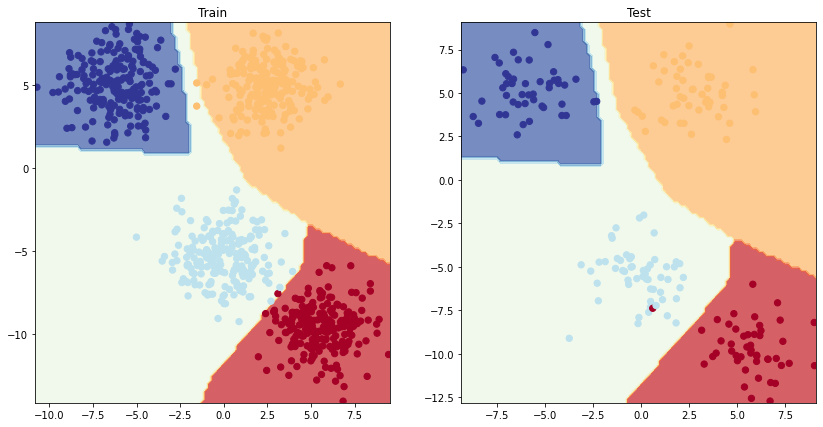

In [125]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)

# 9. Classification metrics

**🟦EN**:
* Accuracy = out of 100 samples, how many does out model get right?
* Recall
* F1-Score
* Precision
* Confusión matrix
* Classification report

**🟥ES**:
* Accuracy = De 100 muestras, ¿cuántas acierta nuestro modelo?
* Recall
* F1-Score
* Precision
* Confusión matrix
* Classification report

In [127]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 9.5 MB/s eta 0:00:00


In [131]:
from torchmetrics import Accuracy

# Setup metric
torchmetrics_acc = Accuracy(task="multiclass", num_classes=OUT_DIM).to(device)

# Calculate
torchmetrics_acc(y_preds, y_test)

tensor(0.9950)